## Import Dependencies and Dataframe

In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})

In [2]:
df = p.load(open('df.p','rb'))

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

## Book-Keeping Functions with Examples

In [3]:
# Book-keeping Functions
n_splits = 1

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

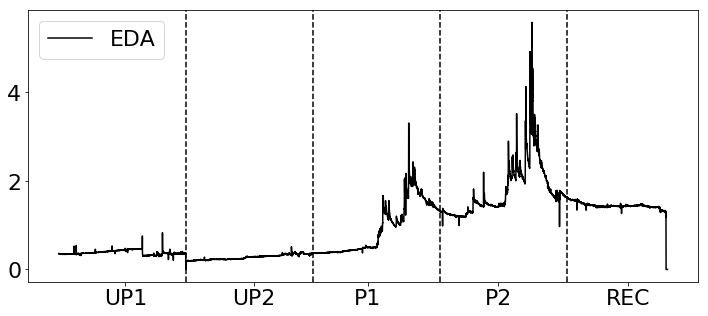

In [17]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize = (12,5))
plot_full_experiment('EDA',26),
plt.xticks([4100, 12000, 19000, 27000, 35000], ['UP1', 'UP2', 'P1', 'P2', 'REC']);

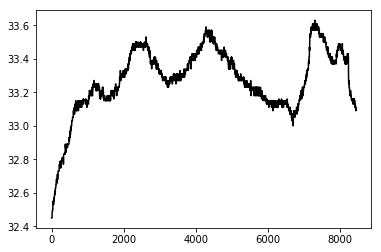

In [5]:
plt.plot(get_signal('TEMP',1,41), 'k') ## Gets the signal for any epoch, with epochs numbered 0-4

## Feature Sandbox

### Duplicate the following entire section for each function you want to write:

#### Feature 1: HR Frequency Mode

In [6]:
# Get sample signal 

signal = get_signal('HR', 3, 12)

# Define analysis function

def mode_frequency(signal):
    fs,pxx = sig.welch(signal, nfft = 1000, scaling = 'spectrum', detrend = 'constant')
    return fs[np.argmax(pxx)]

# Test function

mode_frequency(signal)

0.004

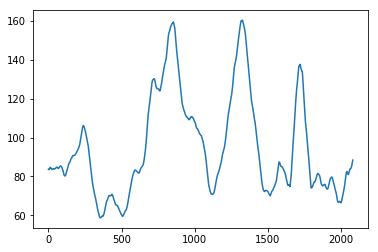

In [7]:
plt.plot(signal)

In [13]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];
n_splits = 1

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('HR',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = mode_frequency(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 401.96it/s]


ANOVA P-value = 0.415


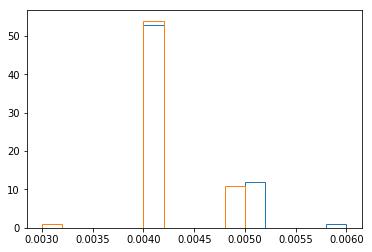

In [14]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Feature 2: EDA Median

In [8]:
# Get sample signal 

signal = get_signal('EDA', 0, 13)

# Define analysis function

def median(signal):
    median = np.median(signal)
    return median

# Test function

median(signal)

0.18955999999999998

In [9]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = median(eda_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 639.21it/s]


ANOVA P-value = 0.046


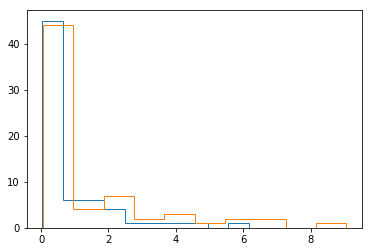

In [10]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Feature 3: First Difference Mean

In [16]:
# Get sample signal 

signal = get_signal('EDA', 3, 13)

# Define analysis function

def first_diff_mean(signal):
    fdm = abs(np.diff(signal, n=1))
    return np.mean(fdm)

# Test function

first_diff_mean(signal)

0.0014827585449218748

In [23]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];
n_splits = 20
for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = first_diff_mean(eda_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 43.64it/s]


ANOVA P-value = 0.000


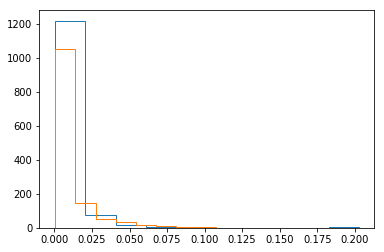

In [24]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

### Feature 4: First Difference Std

In [25]:
# Get sample signal 

signal = get_signal('EDA', 3, 13)

# Define analysis function

def first_diff_std(signal):
    fdm = abs(np.diff(signal, n=1))
    return np.std(fdm)

# Test function

first_diff_std(signal)

0.01039225587025276

In [26]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = first_diff_std(eda_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 42.47it/s]


ANOVA P-value = 0.000


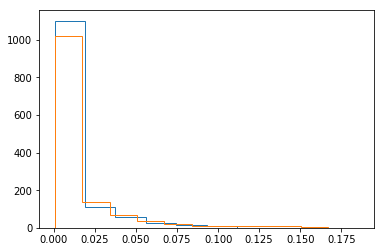

In [27]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Feature 5: Second Difference Mean

In [28]:
# Get sample signal 

signal = get_signal('EDA', 3, 13)

# Define analysis function

def sec_diff_mean(signal):
    fdm = abs(np.diff(signal, n=2))
    return np.mean(fdm)

# Test function

sec_diff_mean(signal)

0.0023686827005249666

In [29]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = sec_diff_mean(eda_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 44.43it/s]


ANOVA P-value = 0.001


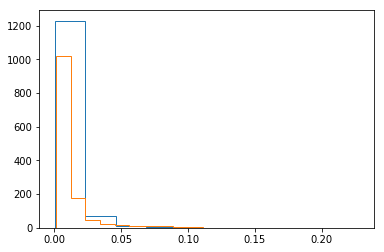

In [30]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

### Feature 6: Second Difference Std

In [21]:
# Get sample signal 

signal = get_signal('EDA', 3, 13)

# Define analysis function

def sec_diff_std(signal):
    fdm = abs(np.diff(signal, n=2))
    return np.std(fdm)

# Test function

sec_diff_std(signal)

0.016341185224222045

In [22]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = sec_diff_std(eda_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 700.22it/s]


ANOVA P-value = 0.513


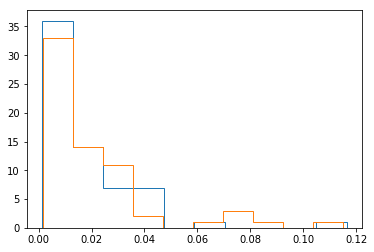

In [23]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

### Features 7-13: Orienting Responses

In [31]:
# Get sample signal 

signal = get_signal('EDA', 3, 13)

# Define analysis function

def orienting_responses(signal):
    #onsets
    inds_on = sig.argrelextrema(signal, np.less)[0]
    num_onsets = len(inds_on)
    onsets = []
    for i in inds_on:
        onsets.append(signal[i])
    sum_onsets = sum(onsets)
    
    #peaks
    inds_peak = sig.argrelextrema(signal, np.greater)[0]
    
    #finding relevant peaks
    peak_list = []
    for i in range(len(inds_on)-1):
        all_peaks_list = np.logical_and(inds_peak > inds_on[i], inds_peak < inds_on[i+1])
        peak_list.append(max(all_peaks_list))
    
    rel_inds_peak = np.asarray(peak_list)
    
    sum_peaks = sum(rel_inds_peak)
    sum_diff = sum_peaks-sum_onsets
            
    orienting_duration = []
    for i in range(len(rel_inds_peak)):
        orienting_duration.append(rel_inds_peak[i]-onsets[i])
    mean_od = np.mean(orienting_duration)
    sum_od = sum(orienting_duration)
    
    areas = []
    for i in range(len(inds_on)-1):
        areas.append(0.5*orienting_duration[i]*rel_inds_peak[i])
    
    sum_areas = sum(areas)
    
    
    return [num_onsets, sum_onsets, sum_peaks, sum_diff, sum_areas, mean_od, sum_od]

# Test function

orienting_responses(signal)

[922,
 165.9137309999996,
 691,
 525.0862690000004,
 282.84621449999963,
 0.5703640380021715,
 525.3052789999995]

In [32]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[0] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:16<00:00,  2.04it/s]


ANOVA P-value = 0.238


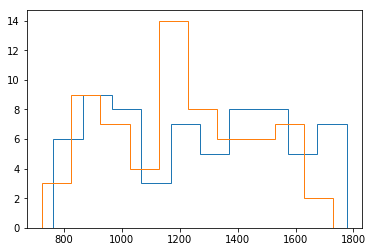

In [27]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum Onsets

In [28]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[1] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

 73%|███████▎  | 24/33 [03:09<00:59,  6.56s/it]

KeyboardInterrupt: 

ANOVA P-value = 0.169


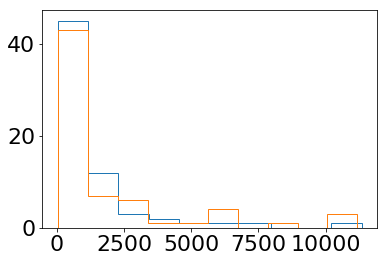

In [107]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum Peaks

In [108]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[2] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [05:07<00:00,  9.00s/it]


ANOVA P-value = 0.390


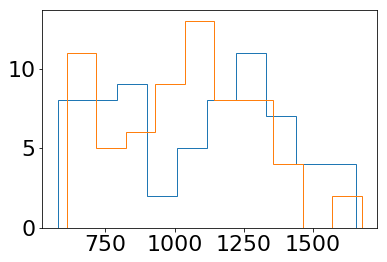

In [109]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Difference Between Sum of Peaks and Onsets

In [110]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[3] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [05:31<00:00,  9.12s/it]


ANOVA P-value = 0.118


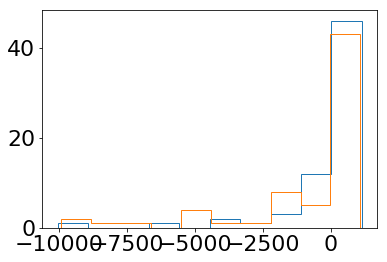

In [111]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum of Areas

In [12]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[4] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [06:37<00:00, 17.68s/it]


ANOVA P-value = 0.117


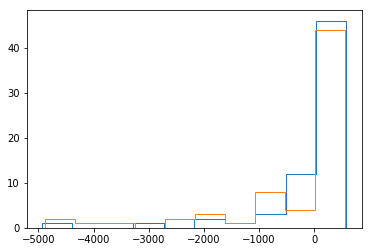

In [13]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Mean Orienting Response Duration

In [14]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[5] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [09:50<00:00, 12.11s/it]


ANOVA P-value = 0.059


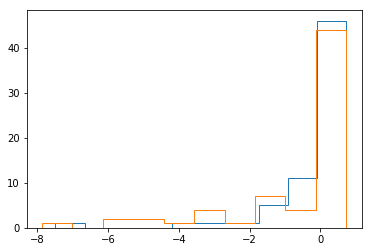

In [16]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum of Durations

In [19]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_responses(eda_signal)[6] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [06:10<00:00, 10.87s/it]


ANOVA P-value = 0.118


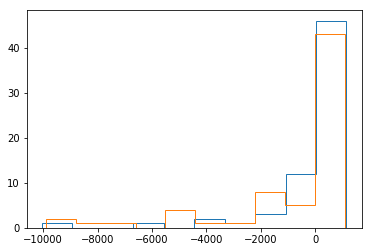

In [20]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

### Figuring out Peaks Function

32
[31, 172.34610000000004, 207.8343999999999, 35.48829999999987, 130.31477067, 1.1447838709677418, 35.488299999999995, 6.131943548387096]


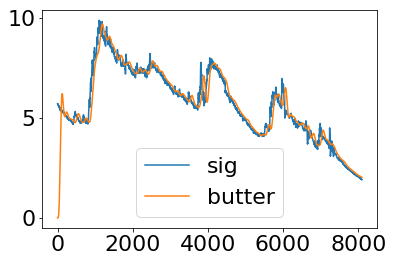

In [18]:
signal = get_signal('EDA', 3, 14)
def filter_signal(signal):
    #want a 5th order butterworth filter 
    #digital filter
    #fs = 32 hz
    n, Wn = sig.buttord(8/500, 32/500, 3, 60)
    b,a = sig.butter(n,Wn)
    new_sig = sig.lfilter(b,a,signal)
    #get filtered data --> find max and min value between 2 peaks -- make those peaks and onsets? 
    return new_sig

def orienting_features(signal):
    #get_peaks
    filtered_sig = filter_signal(signal)
    bounds = sig.argrelextrema(filtered_sig, np.greater)[0]
    max_list = []
    min_list = []
    for i in range(len(bounds)-1):
        b1 = bounds[i]
        b2 = bounds[i+1]
        max_list.append(max(signal[b1:b2]))
        min_list.append(min(signal[b1:b2]))
    
    num_onsets = len(min_list)
    sum_onsets = sum(min_list)
    sum_peaks = sum(max_list)
    sum_diff = sum_peaks-sum_onsets
            
    orienting_duration = []
    for i in range(len(max_list)):
        orienting_duration.append(max_list[i]-min_list[i])
    mean_od = np.mean(orienting_duration)
    sum_od = sum(orienting_duration)
    
    areas = []
    for i in range(len(min_list)):
        areas.append(0.5*orienting_duration[i]*max_list[i])
    
    sum_areas = sum(areas)
    
    mean_amplitude = []
    for i in range(len(max_list)):
        mean_amplitude.append((max_list[i]+min_list[i])/2)
    
    mean_amp = np.mean(mean_amplitude)
    
    print(len(bounds))
    for i in range(len(bounds)-1):
        b = bounds[i]
        #plt.plot(b, max_list[i],'o')
    
    return [num_onsets, sum_onsets, sum_peaks, sum_diff, sum_areas, mean_od, sum_od, mean_amp]


butter = filter_signal(signal)
plt.plot(signal, label = 'sig')
plt.plot(butter, label = 'butter')
plt.legend()
of = orienting_features(signal)
print(of)

In [26]:
#using findpeaks
ii = np.random.randint(0,len(all_subjects))
jj = np.random.randint(0,4)


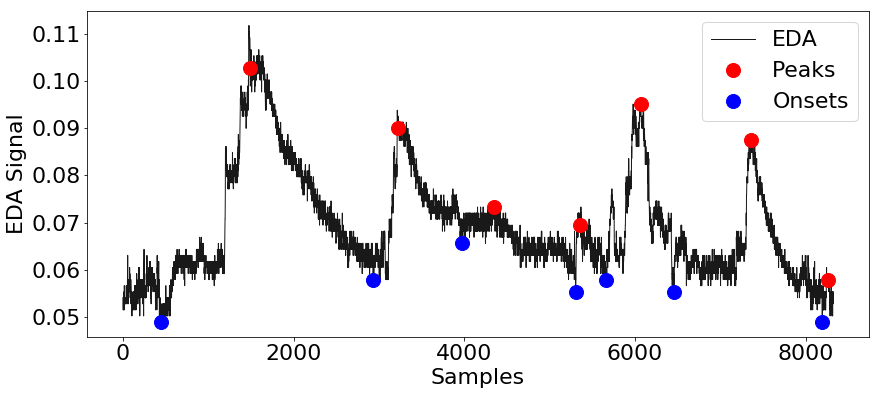

In [46]:
from scipy.signal import medfilt
signal = get_signal('EDA',jj,all_subjects[ii])
def find_peaks(signal):
    #normalize function
    norm_signal = medfilt((signal-np.mean(signal))/np.std(signal), 31)
    #find peaks
    peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/12, prominence = 0.25)
    if len(peaks) == 0:
        peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/14, prominence = 0.1)
    min_0 = np.argmin(signal[0:peaks[0]])
    min_peaks = [min_0]
    for i in range(1,len(peaks)):
        min_i = np.argmin(signal[peaks[i-1]:peaks[i]])
        min_peaks.append((peaks[i-1]+min_i))
    return peaks, min_peaks

peaks, onsets = find_peaks(signal)

plt.figure(figsize = (14,6))
plt.plot(signal, 'k', label = 'EDA', linewidth = 1, alpha = 0.9)
plt.plot(peaks, signal[peaks], 'ro', markersize = 14, label = 'Peaks')
plt.plot(onsets, signal[onsets], 'bo', markersize = 14, label = 'Onsets')

def orienting_features(signal):
    peaks, onsets = find_peaks(signal)
    num_onsets = len(onsets)
    sum_peaks = sum(signal[peaks])
    sum_onsets = sum(signal[onsets])
    sum_difference = sum_peaks - sum_onsets
    
    orienting_duration = []
    for i in range(len(peaks)):
        orienting_duration.append(peaks[i]-onsets[i])
    mean_od = np.mean(orienting_duration)
    sum_od = sum(orienting_duration)
    
    areas = []
    for i in range(len(peaks)):
        areas.append(0.5*orienting_duration[i]*peaks[i])
    
    sum_areas = sum(areas)
    
    mean_amplitude = []
    for i in range(len(peaks)):
        mean_amplitude.append((peaks[i]+onsets[i])/2)
    
    mean_amp = np.mean(mean_amplitude)
    total_amp = sum(mean_amplitude)
    return [num_onsets, sum_onsets, sum_peaks, sum_difference, sum_areas, sum_od, mean_od, mean_amp, total_amp]

plt.xlabel('Samples')
plt.ylabel('EDA Signal')
plt.legend();

plt.savefig('eda_peaks.pdf')

# Re-running Orienting Responses with filtered signal

#### Number of Peaks

In [48]:
n_splits = 1

In [53]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[0] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.19it/s]


ANOVA P-value = 0.041


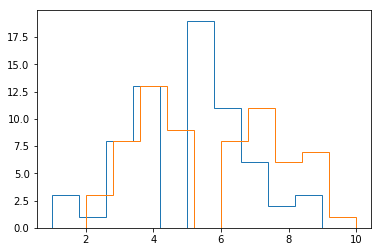

In [54]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum of Onsets

In [55]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[1] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.27it/s]


ANOVA P-value = 0.011


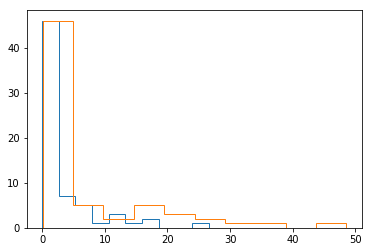

In [56]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum of Peaks

In [57]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[2] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.36it/s]


ANOVA P-value = 0.045


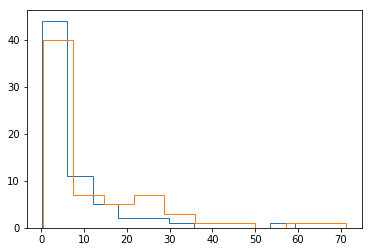

In [58]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum Difference

In [59]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[3] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.39it/s]


ANOVA P-value = 0.360


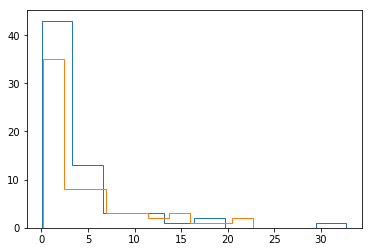

In [60]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum Areas

In [61]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[4] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.22it/s]


ANOVA P-value = 0.331


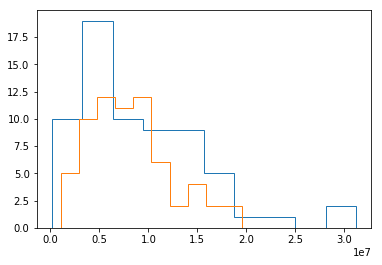

In [62]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum Orienting Duration

In [63]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[5] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.30it/s]


ANOVA P-value = 0.594


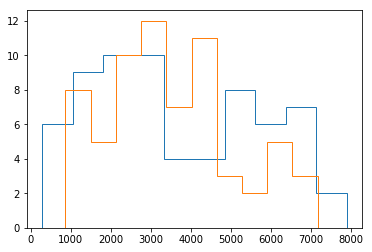

In [64]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Mean Orienting Duration

In [65]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[6] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 22.29it/s]


ANOVA P-value = 0.127


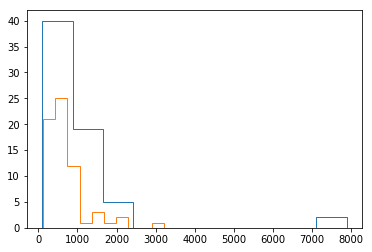

In [66]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Mean Amplitude

In [67]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[7] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 21.84it/s]


ANOVA P-value = 0.027


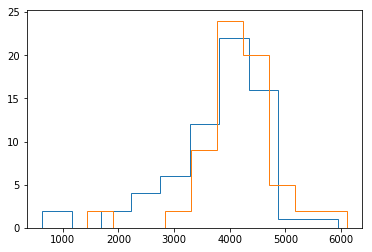

In [68]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Sum Amplitude

In [69]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = orienting_features(eda_signal)[8] ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:01<00:00, 21.67it/s]


ANOVA P-value = 0.006


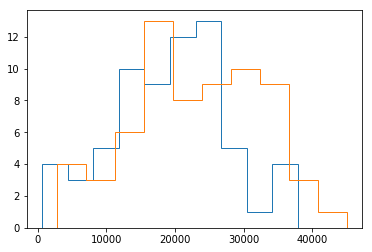

In [70]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

# Adapting Vedant's Frequency Code

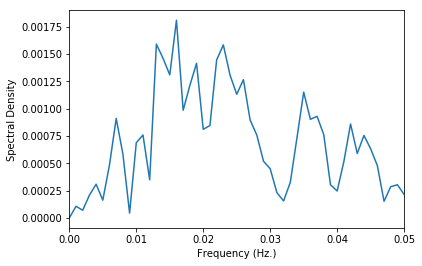

In [325]:
#Get sample signal

signal = get_signal('EDA', 4, 33)

#Define analysis function
def EDA_passbands(signal):
    fs,pxx = sig.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'linear')
    # plt.figure()
    # plt.plot(fs,pxx)
    # plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')

    vlfband = (fs > 0.001)*(fs < 0.045)
    lfband = (fs > 0.045)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.25)

    # plt.figure(figsize = (13,7))
    # plt.plot(fs,pxx,'k')
    # #plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')
    # plt.plot(fs,vlfband*np.max(pxx),label = 'VLF')
    # plt.plot(fs,lfband*np.max(pxx),label = 'LF')
    # plt.plot(fs,hfband*np.max(pxx),label = 'HF')
    # plt.title('IBI Frequency Passbands')
    # plt.legend()

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband])
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]
    

#test function

eda_passbands(signal)

In [326]:
allfeatures = [];
targets = [];
n_splits = 10

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            eda_signal = get_split_signal('EDA',epoch,subjno,splitno)
            

            allfeature = EDA_passbands(eda_signal)
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['vlf','hf','lf']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)
targets = np.asarray(targets)

100%|██████████| 33/33 [00:01<00:00, 22.63it/s]


F_onewayResult(statistic=31.99018653631225, pvalue=1.898042938164128e-08)

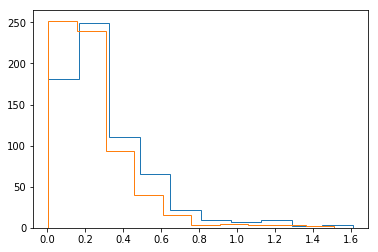

In [327]:
fdf['lf/hf'] = fdf['lf'] / (fdf['hf'])
up = np.asarray(fdf['lf/hf'][targets == 0])
p = np.asarray(fdf['lf/hf'][targets == 1])
plt.hist(up, histtype = 'step');
plt.hist(p, histtype = 'step');
nonan = (~np.isnan(p)) * (~np.isnan(up))
stats.f_oneway(up[nonan],p[nonan])